# Exercise : Computer Vision

# Face Expression Recognition 

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

In [ ]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load dataset 

Let's download and load the dataset and display a few random samples from it:

In [ ]:
url = 'https://drive.google.com/uc?id=1LlETXfU2Hw1yWe2iKbjA_gJ8MSB4tEVd'
output = 'FER2013.csv'
data = pd.read_csv(gdown.download(url, output, quiet=False))
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()

print(f"\ntrain shape: {data_train.shape}, \nvalidation shape: {data_val.shape}, \ntest shape: {data_test.shape}")

Downloading...
From: https://drive.google.com/uc?id=1LlETXfU2Hw1yWe2iKbjA_gJ8MSB4tEVd
To: /content/FER2013.csv
301MB [00:03, 87.5MB/s]



train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [ ]:
for i in data_val.index:
  print (i)

28709
28710
28711
28712
28713
28714
28715
28716
28717
28718
28719
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
28756
28757
28758
28759
28760
28761
28762
28763
28764
28765
28766
28767
28768
28769
28770
28771
28772
28773
28774
28775
28776
28777
28778
28779
28780
28781
28782
28783
28784
28785
28786
28787
28788
28789
28790
28791
28792
28793
28794
28795
28796
28797
28798
28799
28800
28801
28802
28803
28804
28805
28806
28807
28808
28809
28810
28811
28812
28813
28814
28815
28816
28817
28818
28819
28820
28821
28822
28823
28824
28825
28826
28827
28828
28829
28830
28831
28832
28833
28834
28835
28836
28837
28838
28839
28840
28841
28842
28843
28844
28845
28846
28847
28848
28849
28850
28851
28852
28853
28854
28855
28856
28857
28858
28859
28860
28861
28862
28863
28864
28865
28866
28867
28868
28869
28870
28871
28872
28873
28874
2887

In [ ]:
def get_formatted_file(df):
    rows = []
    for i in df.index:
      row = np.array(data['pixels'][i].split(), dtype='float32').reshape(48,48)
      rows.append(row)
     
    data_X = np.array(rows)
    data_Y = np.array(df['emotion'])
    print(f'X shape: {data_X.shape}, Y shape: {data_Y.shape}')
    return data_X, data_Y

    
X_train, y_train = get_formatted_file(data_train) #training data
val_X, val_Y     = get_formatted_file(data_val) #validation data
X_test, y_test   = get_formatted_file(data_test) #test data

X shape: (28709, 48, 48), Y shape: (28709,)
X shape: (3589, 48, 48), Y shape: (3589,)
X shape: (3589, 48, 48), Y shape: (3589,)


In [ ]:
X_train = np.expand_dims(X_train, axis = -1)/255
X_test = np.expand_dims(X_test, axis = -1)/255
val_X = np.expand_dims(val_X, axis = -1)/255

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, val_X shape: {val_X.shape}')

X_train shape: (28709, 48, 48, 1), X_test shape: (3589, 48, 48, 1), val_X shape: (3589, 48, 48, 1)


In [ ]:
class_names = ['Angry','Digust', 'Fear','Happy', 'Sad', 'Surprise', 'Neutral']

Our training set is made up of 48x48 grayscale images.
Let's visualize what some of these images and their corresponding training labels look like.

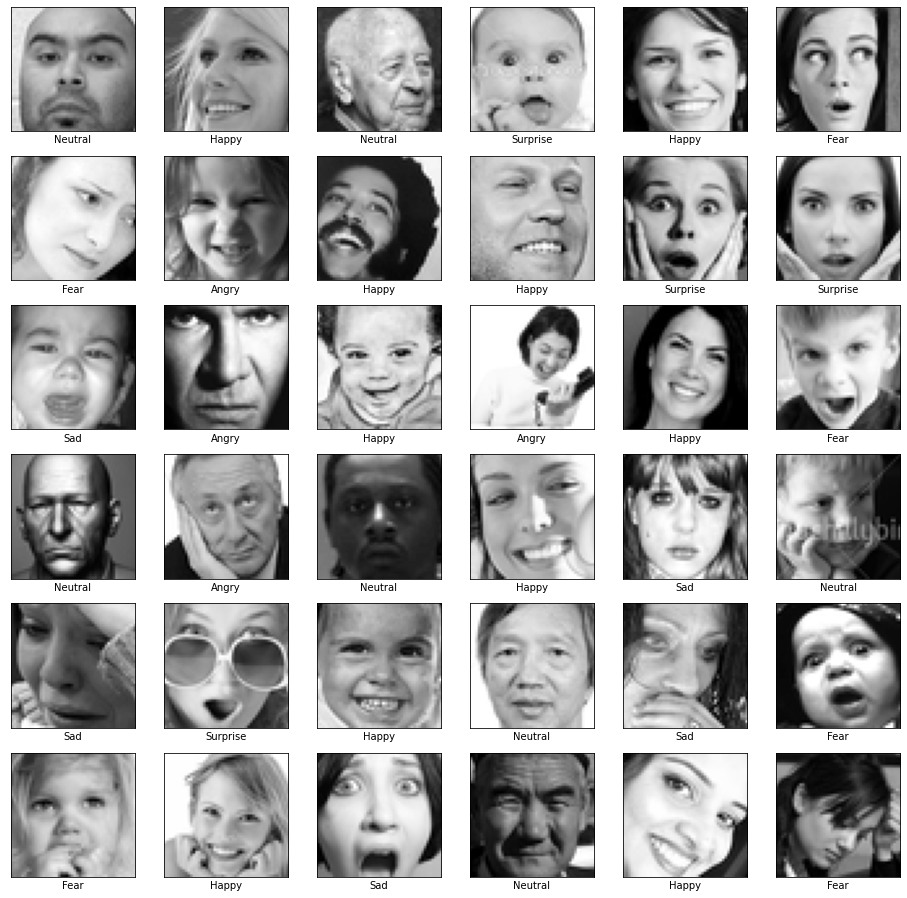

In [ ]:
plt.figure(figsize=(16,16))
random_inds = np.random.choice(20000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_train[image_ind]), cmap=plt.cm.gray)
    plt.xlabel(class_names[y_train[image_ind]])

## Convolutional Neural Network (CNN) for fashion dataset

In [ ]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_features = 64

### Define the CNN model

We will explore two new types of layers : [`keras.layers.Conv2D` ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to define convolutional layers and [`keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) to define the pooling layers. Let us use the parameters shown in the network architecture above.

In [ ]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
      # Module - 1 (try more than one module of Conv2D and Maxpool layers)
      # Try adding Batchnormalisation layer
      tf.keras.layers.BatchNormalization(),
        # Define the first convolutional layer
      tf.keras.layers.Conv2D(filters=50,kernel_size=(3,3),activation='relu'),
        # Define the first max pooling layer
      tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=1),
      tf.keras.layers.Conv2D(filters=50,kernel_size=(3,3),activation='relu'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=1),
      tf.keras.layers.Conv2D(filters=50,kernel_size=(3,3),activation='relu'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=1),
      
      # Flattening
        tf.keras.layers.Flatten(),

      # Dense layers. Try using Dropout layer
        tf.keras.layers.Dense(units=128,activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=128,activation='relu'),
        tf.keras.layers.Dropout(0.2),

        # output
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()
# Initialize the model by passing some data through


In [ ]:
cnn_model.predict(X_train[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 48, 48, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 50)        500       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 43, 50)        22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 50)        22550     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 39, 39, 50)        0

### Train and test the CNN model

Let us define the loss function, optimizer, and metrics in the`compile` method.

In [ ]:
#Define the compile operation with optimizer, loss function and learning rate

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

As was the case with the fully connected model, we can train our CNN using the `fit` method via the Keras API.

In [ ]:
batch = 64
epoch_count = 25

# Bringing some variation to the image
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# Stops the epochs early if there is no improvement in performance
es = EarlyStopping(monitor='val_loss', 
                   patience = 10, 
                   mode = 'min', 
                   verbose = 1,
                   restore_best_weights=True)

#Train the CNN model with fit function
cnn_model.fit(data_generator.flow(X_train, y_train, batch), 
              batch_size=batch, 
              epochs=epoch_count, 
              callbacks = [es],
              verbose = 2,
              validation_data=(val_X, val_Y))

Epoch 1/25
449/449 - 14s - loss: 1.7429 - accuracy: 0.2943 - val_loss: 1.5184 - val_accuracy: 0.4205
Epoch 2/25
449/449 - 14s - loss: 1.5838 - accuracy: 0.3759 - val_loss: 1.4378 - val_accuracy: 0.4458
Epoch 3/25
449/449 - 14s - loss: 1.4885 - accuracy: 0.4170 - val_loss: 1.3549 - val_accuracy: 0.4932
Epoch 4/25
449/449 - 14s - loss: 1.4376 - accuracy: 0.4395 - val_loss: 1.3473 - val_accuracy: 0.4873
Epoch 5/25
449/449 - 14s - loss: 1.4018 - accuracy: 0.4600 - val_loss: 1.2847 - val_accuracy: 0.5102
Epoch 6/25
449/449 - 14s - loss: 1.3741 - accuracy: 0.4679 - val_loss: 1.2656 - val_accuracy: 0.5143
Epoch 7/25
449/449 - 14s - loss: 1.3538 - accuracy: 0.4748 - val_loss: 1.2795 - val_accuracy: 0.5065
Epoch 8/25
449/449 - 14s - loss: 1.3320 - accuracy: 0.4853 - val_loss: 1.2221 - val_accuracy: 0.5297
Epoch 9/25
449/449 - 14s - loss: 1.3213 - accuracy: 0.4898 - val_loss: 1.2333 - val_accuracy: 0.5235
Epoch 10/25
449/449 - 14s - loss: 1.3067 - accuracy: 0.4962 - val_loss: 1.2313 - val_accura

Let's evaluate its perforance on the test dataset using the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method:

In [ ]:
'''Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
test_loss1, test_acc1 = cnn_model.evaluate(X_train, y_train)
print('Test accuracy - Test:', test_acc)
print('Train accuracy - Train:', test_acc1)

898/898 [==============================] - 4s 4ms/step - loss: 1.0933 - accuracy: 0.5844
Test accuracy - Test: 0.5594873428344727
Train accuracy - Train: 0.5844160318374634


### Make predictions with the CNN model



In [ ]:
predictions = cnn_model.predict(X_test)

In [ ]:
predictions[0]

array([0.39174104, 0.0564624 , 0.13727458, 0.00172025, 0.20104188,
       0.0500666 , 0.16169326], dtype=float32)

Prediction is : Neutral
Label is      : Sad


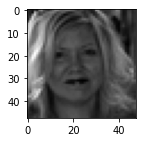

In [ ]:
'''identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
item = np.random.randint(0,1000)
prediction = np.argmax(predictions[item])

print(f'Prediction is : {class_names[prediction]}')
print(f'Label is      : {class_names[y_test[item]]}')
plt.figure (figsize= (2,2))
plt.imshow(X_test[item,:,:,0], cmap=plt.cm.gray)

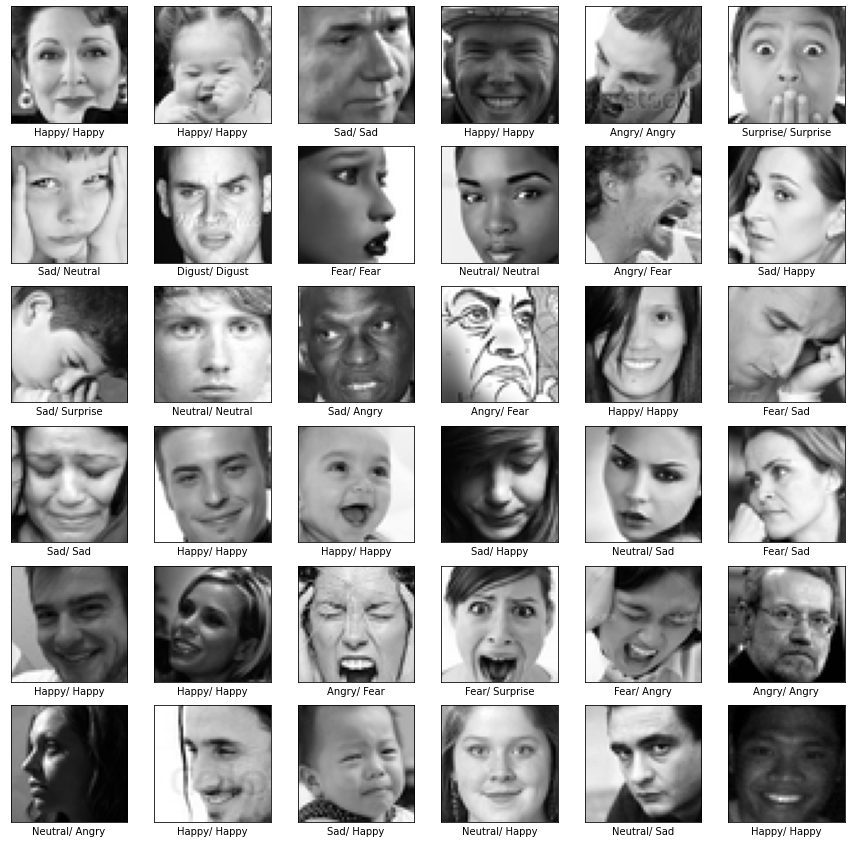

In [ ]:
plt.figure(figsize=(15,15))
random_inds = np.random.choice(X_test.shape[0],36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_test[image_ind]), cmap=plt.cm.gray)
    prediction = np.argmax(predictions[image_ind])

    plt.xlabel(class_names[y_test[image_ind]]+ '/ '+class_names[prediction])